In [1]:
# Import necessary packages and libraries to start. 

import pandas as pd
import numpy as np
from numpy import cumsum
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import scipy
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Using pandas, import dataset into data frame. preview with head.

df = pd.read_csv('C://Users//cseba//Documents//WGU//D214 Data Analytics Graduate Capstone//Potential Data Sets//Walmart Daily Stock Prices 1972 - 2022.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,8/25/1972,0.063477,0.064697,0.063477,0.064453,0.036175,2508800
1,8/28/1972,0.064453,0.064941,0.064209,0.064209,0.036038,972800
2,8/29/1972,0.063965,0.063965,0.063477,0.063477,0.035627,1945600
3,8/30/1972,0.063477,0.063477,0.062988,0.063477,0.035627,409600
4,8/31/1972,0.062988,0.062988,0.062500,0.062500,0.035079,870400


In [3]:
# running .info to check type of data, info, and count. There are 7 columns and confirms that no nulls are present

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12566 entries, 0 to 12565
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       12566 non-null  object 
 1   Open       12566 non-null  float64
 2   High       12566 non-null  float64
 3   Low        12566 non-null  float64
 4   Close      12566 non-null  float64
 5   Adj Close  12566 non-null  float64
 6   Volume     12566 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 687.3+ KB


In [4]:
# display data to find any issues if there are any. There appears to be 12565 days total.

pd.set_option("display.max_columns", None)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,8/25/1972,0.063477,0.064697,0.063477,0.064453,0.036175,2508800
1,8/28/1972,0.064453,0.064941,0.064209,0.064209,0.036038,972800
2,8/29/1972,0.063965,0.063965,0.063477,0.063477,0.035627,1945600
3,8/30/1972,0.063477,0.063477,0.062988,0.063477,0.035627,409600
4,8/31/1972,0.062988,0.062988,0.062500,0.062500,0.035079,870400
...,...,...,...,...,...,...,...
12561,6/17/2022,120.019997,120.879997,117.970001,118.290001,118.290001,12166700
12562,6/21/2022,118.300003,122.779999,118.220001,122.169998,122.169998,7972200
12563,6/22/2022,122.099998,123.250000,120.589996,120.690002,120.690002,6745000
12564,6/23/2022,121.750000,123.959999,121.199997,123.620003,123.620003,6013600


In [5]:
# create new df while dropping columns not needed for forecasting. Confirm dropped columns with preview.

df2 = df.drop(columns = ['Open', 'High', 'Low', 'Close', 'Volume'])

df2

,Date,Adj Close
0,8/25/1972,0.036175
1,8/28/1972,0.036038
2,8/29/1972,0.035627
3,8/30/1972,0.035627
4,8/31/1972,0.035079
...,...,...
12561,6/17/2022,118.290001
12562,6/21/2022,122.169998
12563,6/22/2022,120.690002
12564,6/23/2022,123.620003


In [6]:
# Because the data set is so large and we only need a few years to make a prediction, reduce the data set by half for
# the analysis. Being that there are 12566 rows, I'll cut that in half. Followed by, reset the index back to 0. 
# Then preview the changes to confirm it applied.


df2 = df2.iloc[6283:]

df2.reset_index(drop = True, inplace = True)

print(df2.head())
print(df2.tail())


        Date  Adj Close
0   7/9/1997  11.077218
1  7/10/1997  11.550778
2  7/11/1997  11.674317
3  7/14/1997  11.756667
4  7/15/1997  11.777267
           Date   Adj Close
6278  6/17/2022  118.290001
6279  6/21/2022  122.169998
6280  6/22/2022  120.690002
6281  6/23/2022  123.620003
6282  6/24/2022  123.720001


In [7]:
# Convert the 'Date' column from MM/DD/YYYY to YYYY-MM-DD format

df2['Date'] = pd.to_datetime(df2['Date'])

# Display the first few rows to confirm the change

df2.head()

,Date,Adj Close
0,1997-07-09,11.077218
1,1997-07-10,11.550778
2,1997-07-11,11.674317
3,1997-07-14,11.756667
4,1997-07-15,11.777267


In [8]:
# check shape of data to confirm number of rows and columns in the data set.

print(df2.shape)

(6283, 2)


In [9]:
# apply .describe which will only display numeric type columns, in this case, just Adjusted Close for statistical summary 
# (EDA) as the "Date" column is a object data type

df2.describe()

,Date,Adj Close
count,6283,6283.000000
mean,2009-12-31 12:48:28.419544576,55.969398
min,1997-07-09 00:00:00,10.622545
25%,2003-10-06 12:00:00,34.949852
50%,2009-12-31 00:00:00,40.792667
75%,2016-03-30 12:00:00,64.551907
max,2022-06-24 00:00:00,159.290985
std,NaN,32.690372


In [10]:
# .info to confirm the two data type columns mentioned in the previous line.

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6283 entries, 0 to 6282
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6283 non-null   datetime64[ns]
 1   Adj Close  6283 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 98.3 KB


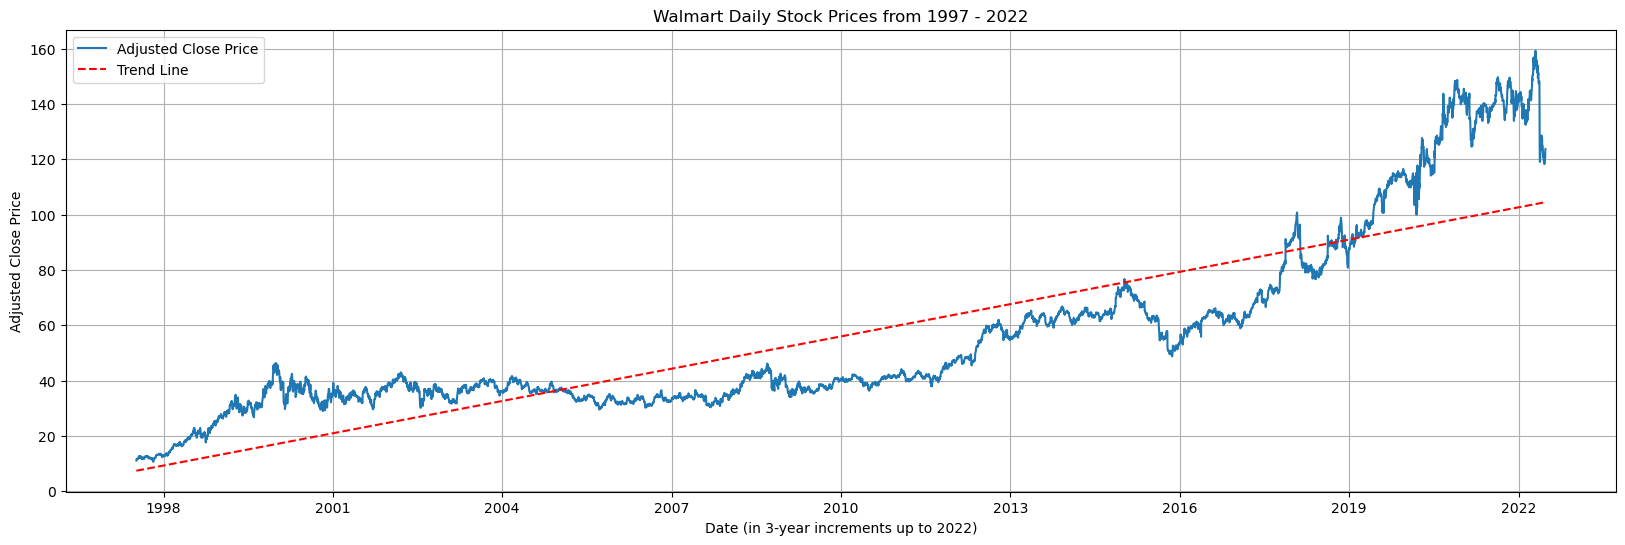

In [11]:
import matplotlib.dates as mdates


# Filter data to include only from 1997 to 2022

start_date = '1997-07-09'
end_date = '2022-06-24'
df2 = df2[(df2['Date'] >= start_date) & (df2['Date'] <= end_date)]

# Plot the Adjusted Close Price data points for the reduced dataset

plt.figure(figsize = (20, 6))
plt.plot(df2['Date'], df2['Adj Close'], label = 'Adjusted Close Price')

# Apply a trend line to determine the trend over time

z = np.polyfit(mdates.date2num(df2['Date']), df2['Adj Close'], 1)
p = np.poly1d(z)
plt.plot(df2['Date'], p(mdates.date2num(df2['Date'])), "r--", label = 'Trend Line')

# Set ticks for the x-axis in order to precisely space the date increments for a clean visual

ax = plt.gca()

# Set major ticks to occur once every 3 years 

ax.xaxis.set_major_locator(mdates.YearLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Label the title, x, and y axis, then show

plt.xlabel('Date (in 3-year increments up to 2022)')
plt.ylabel('Adjusted Close Price')
plt.title('Walmart Daily Stock Prices from 1997 - 2022')
plt.legend()
plt.grid(True)  # Optional: Adds a grid for better readability
plt.show()


In [12]:
# Re-verify that data is cleaned for the performance assessment by dropping any null columns

df2 = df2.dropna()

In [13]:
# Make the 'Date' column of datetime type

df2['Date'] = pd.to_datetime(df2['Date'])

# Use .dt accessor to remove any timezome information that may be associated with the data as it won't be relevant or needed
# for the following steps.

df2['Date'] = df2['Date'].dt.tz_localize(None)


In [14]:
# This concludes the data cleaning and preparation of the data setExport the cleaned data to .csv file after dropping nulls

df2.to_csv(r'C://Users//cseba//Documents//WGU//D214 Data Analytics Graduate Capstone//Task 2 - Data Analytics Report and Executive Summary//clean_df.csv')

In [15]:
# Apply the adf function or the Augmented Dickey-Fuller test in order to make/test the data stationarity.

result = adfuller(df2['Adj Close'])

print("Test statistics: ", result[0])
print("p-value: ", result[1])
print("Critical values: ", result[4])

Test statistics:  -0.03196873417818066
p-value:  0.9558070823091233
Critical values:  {'1%': -3.431396550530024, '5%': -2.8620024825398054, '10%': -2.5670161765106543}


In [16]:
# Apply if and else statement that will print output that determines stationarity if p-value is less than or equal to 0.05, 
# or else it is non-stationary. 

if result[1]<= 0.05:
    print("Reject null hypothesis, the time series is stationary")
else:
    print("Fail to reject null hypothesis, the time series is non-stationary")

Fail to reject null hypothesis, the time series is non-stationary


In [17]:
# Apply diff() to the 'Adj Close' column for stationarity

df_stationary = df2.copy()

df_stationary['Adj Close Differenced'] = df2['Adj Close'].diff().dropna()

# View the data

print(df_stationary[['Date', 'Adj Close', 'Adj Close Differenced']].head())


        Date  Adj Close  Adj Close Differenced
0 1997-07-09  11.077218                    NaN
1 1997-07-10  11.550778               0.473560
2 1997-07-11  11.674317               0.123539
3 1997-07-14  11.756667               0.082350
4 1997-07-15  11.777267               0.020600


In [18]:
# Drop NaNs

df_stationary.dropna(subset = ['Adj Close Differenced'], inplace = True)

# View the data to confirm NaN rows are dropped

print(df_stationary[['Date', 'Adj Close', 'Adj Close Differenced']].head())



        Date  Adj Close  Adj Close Differenced
1 1997-07-10  11.550778               0.473560
2 1997-07-11  11.674317               0.123539
3 1997-07-14  11.756667               0.082350
4 1997-07-15  11.777267               0.020600
5 1997-07-16  11.797855               0.020588


In [19]:
# Drop Adj Close column which is not needed for forecasting. Confirm dropped columns with preview.

df_stationary = df_stationary.drop(columns = ['Adj Close'])

df_stationary

,Date,Adj Close Differenced
1,1997-07-10,0.473560
2,1997-07-11,0.123539
3,1997-07-14,0.082350
4,1997-07-15,0.020600
5,1997-07-16,0.020588
...,...,...
6278,2022-06-17,-2.330002
6279,2022-06-21,3.879997
6280,2022-06-22,-1.479996
6281,2022-06-23,2.930001


In [20]:
# Test again using adf on df_stationary to confirm if the time series is stationary with a p-value <= 0.05.

result = adfuller(df_stationary['Adj Close Differenced'])

print("Test statistics: ", result[0])
print("p-value: ", result[1])
print("Critical values: ", result[4])

if result[1]<= 0.05:
    print("Reject null hypothesis, the time series is stationary")
else:
    print("Fail to reject null hypothesis, the time series is non-stationary")

Test statistics:  -16.343480411762208
p-value:  2.9800902148496136e-29
Critical values:  {'1%': -3.431396550530024, '5%': -2.8620024825398054, '10%': -2.5670161765106543}
Reject null hypothesis, the time series is stationary


Text(0, 0.5, 'Differenced Adjusted Closed')

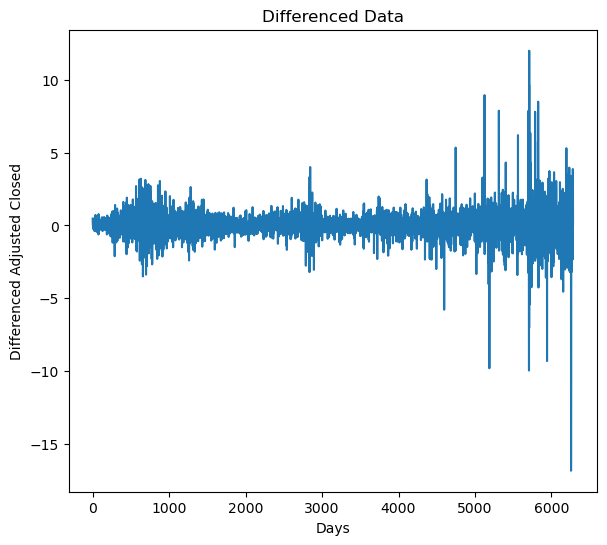

In [21]:
# Plot visualization of difference data to prove stationarity, which centers on zero. This means the value of d is 1, due to
# the data only having to be differenced one time in order to make it stationary.

plt.figure(figsize=(15, 6))
plt.subplot(122)
plt.plot(df_stationary['Adj Close Differenced'])
plt.title('Differenced Data')
plt.xlabel('Days')
plt.ylabel('Differenced Adjusted Closed')

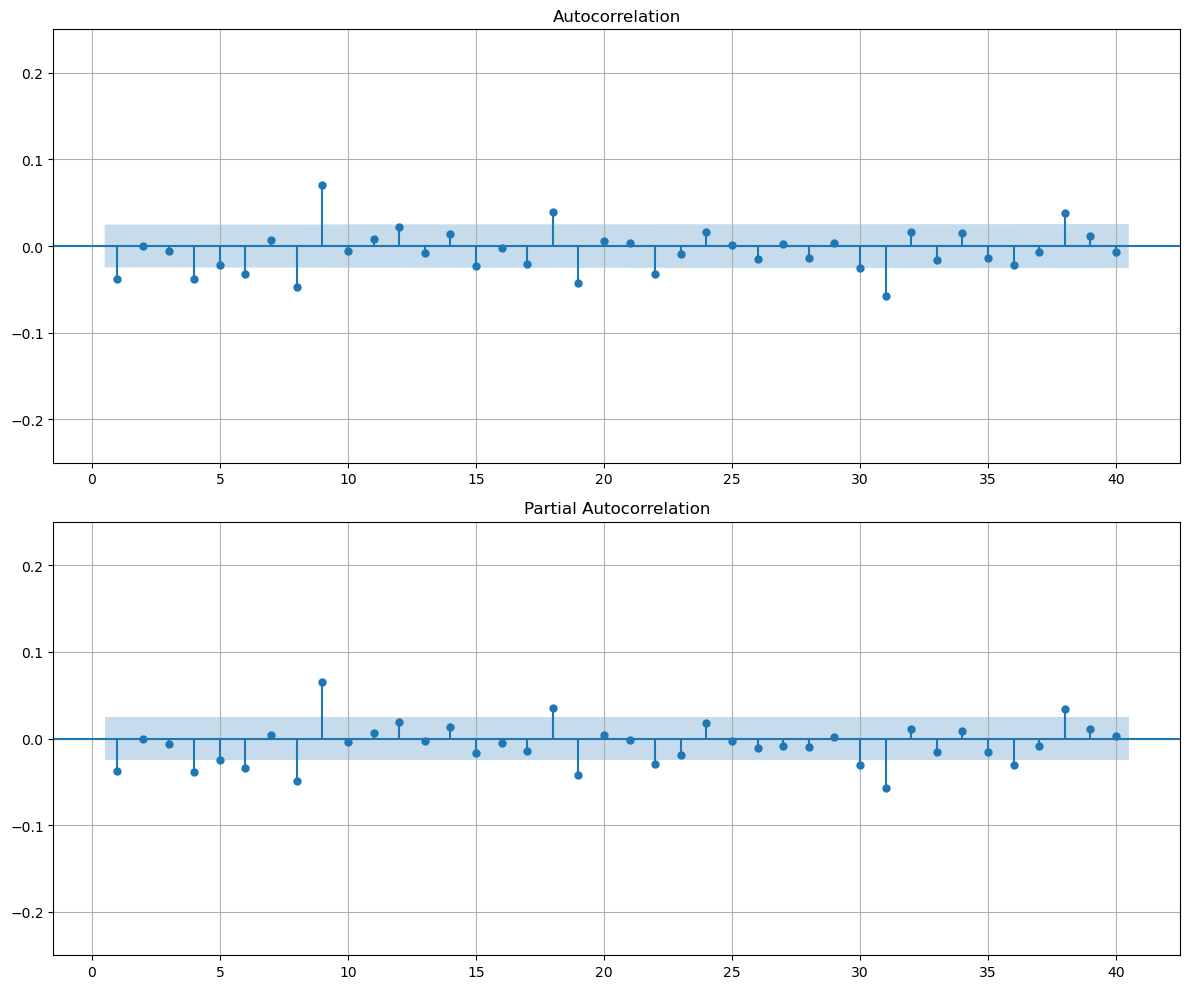

In [22]:
# Now that data is stationary, find pacf and acf
# Use autocorrelation plots to determine the ACF and PACF values
# Import plot_acf and plot_pacf from statsmodels to find the values

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Make figure

fig, (ax1, ax2) = plt.subplots(2,1, figsize = (12,10))

# Plotting the ACF

plot_acf(df_stationary['Adj Close Differenced'], lags = 40, zero = False, ax = ax1)
ax1.grid(True)
ax1.set_ylim([-0.25, 0.25])

# Plotting the PACF

plot_pacf(df_stationary['Adj Close Differenced'], lags = 40, zero = False, ax = ax2)
ax2.grid(True)
ax2.set_ylim([-0.25, 0.25])

# Display plots

plt.tight_layout()
plt.show()

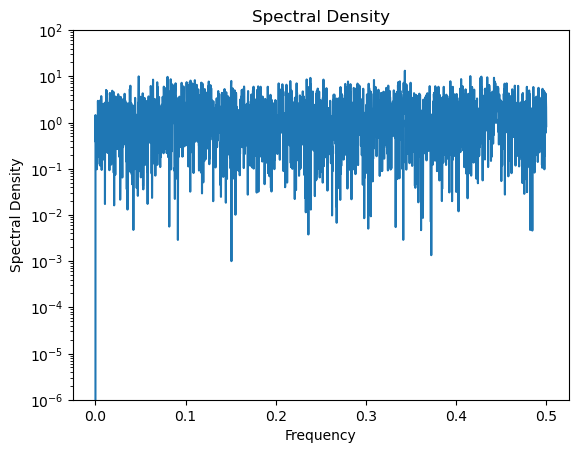

In [23]:
# Based on the graphs on the previous line, pacf = 1 and acf = 1. p,d,q = (1,1,1). Next, run spectral density.
# import signal from scipy for spectral density

from scipy import signal

# Now, run spectral density

f, Pxx_den = signal.periodogram(df_stationary['Adj Close Differenced'])
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e2])
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.show()

<AxesSubplot:>

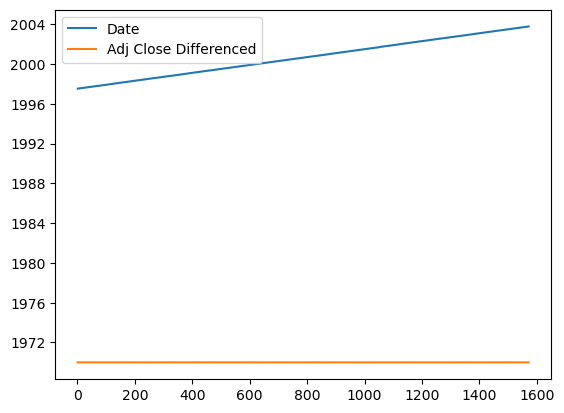

In [24]:
# Now, check for seasonality
# View subset of data to identify seasonality (1/4 of 25 years data set)

df_stationary.iloc[:1572].plot()

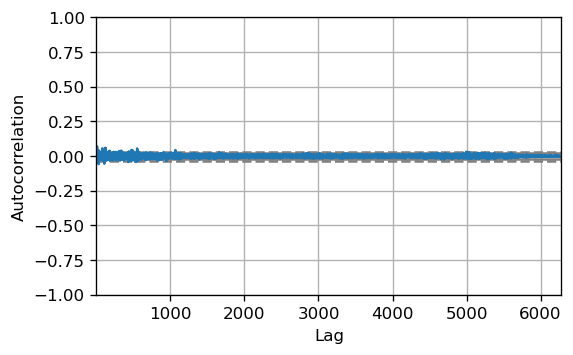

In [25]:
# check for more seasonality

plt.rcParams.update({'figure.figsize':(5,3), 'figure.dpi':120})
autocorrelation_plot(df_stationary['Adj Close Differenced'].tolist())

# Display plot

plt.show()

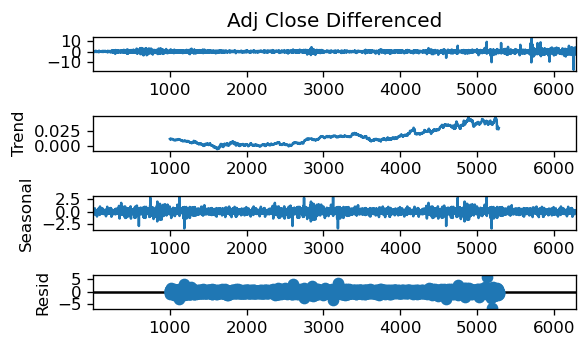

In [26]:
# From here, apply decomposition
# adding the seasonal_decompose function from statsmodels to perform decomposition.

from statsmodels.tsa.seasonal import seasonal_decompose

# Running seasonal decomposition on the data set

decomposition = seasonal_decompose(df_stationary['Adj Close Differenced'], period = 2000)

# Plotting the decomposition 

decomposition.plot()
plt.show()

<AxesSubplot:title={'center':'Seasonality'}>

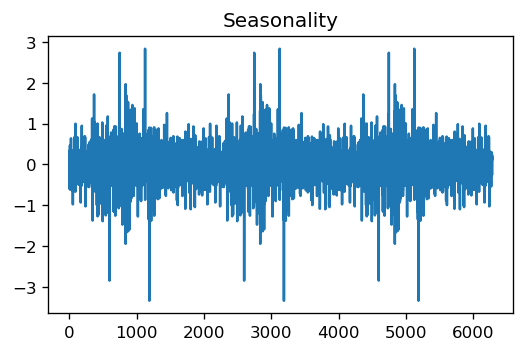

In [27]:
# Plot the seasonality with a more clear and larger visualization

plt.title('Seasonality')
decomposition.seasonal.plot()

<AxesSubplot:title={'center':'Trend'}>

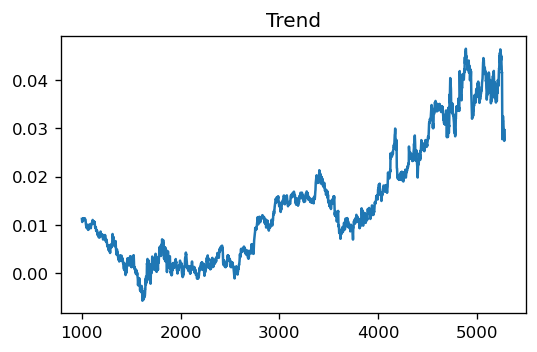

In [28]:
# View larger visualization for trend

plt.title('Trend')
decomposition.trend.plot()

<AxesSubplot:title={'center':'Residual'}>

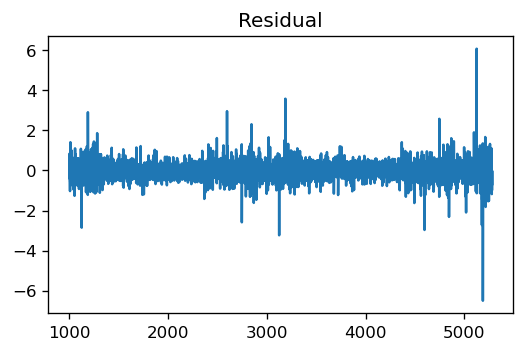

In [29]:
# View larger visualization for the residual.

plt.title('Residual')
decomposition.resid.plot()

In [30]:
# With the time series stationary, both pacf and acf observed, and seasonality was tested/performed with decomposition,
# create a column for "Days" to plot the forecast more easily in an upcoming step. 

df2['Date'] = pd.to_datetime(df2['Date'])
df2.set_index('Date', inplace=True)

# Create the new column with incremental day counts
df2['Day'] = (df2.index - df2.index.min()).days + 1

# Display the first few rows to verify
df2.head()

,Adj Close,Day
Date,,
1997-07-09,11.077218,1
1997-07-10,11.550778,2
1997-07-11,11.674317,3
1997-07-14,11.756667,6
1997-07-15,11.777267,7


In [31]:
# drop the date column now that we have the Day_Count column, but first need to reset the index.
df3 = df2.reset_index().drop(columns = ['Date'])

df3.head()

,Adj Close,Day
0,11.077218,1
1,11.550778,2
2,11.674317,3
3,11.756667,6
4,11.777267,7


In [32]:
# create a train and test split on the original indexed stock data (df). 
# Also, print the shape of the split data sets and compare it to the full data set to confirm appropriate ratio was applied.

print(df3.shape)

train_size = int(len(df3) * 0.8)

# Splitting the data
X_train = df3.iloc[:train_size]
X_test = df3.iloc[train_size:]
print(X_train.shape, X_test.shape)

(6283, 2)
(5026, 2) (1257, 2)


In [33]:
# Export to .csv the train and test sets as required to be submitted for the performance assessment.

X_train.to_csv(r'C://Users//cseba//Documents//WGU//D214 Data Analytics Graduate Capstone//capstone_train.csv')
X_test.to_csv(r'C://Users//cseba//Documents//WGU//D214 Data Analytics Graduate Capstone//capstone_test.csv')

In [34]:
# Preview Begin Date of Test. Note this for later when plotting forecast
X_test

,Adj Close,Day
5026,69.586128,7295
5027,69.058609,7296
5028,68.831238,7297
5029,68.540184,7300
5030,68.503807,7302
...,...,...
6278,118.290001,9110
6279,122.169998,9114
6280,120.690002,9115
6281,123.620003,9116


In [35]:
# Import ARIMA to from statsmodels to run ARIMA and find SARIMAX results

from statsmodels.tsa.arima.model import ARIMA

# Run ARIMA test first time on the training set using original observed p, d, and q values to see results.

p = 1
d = 1
q = 1

model = ARIMA(X_train['Adj Close'], order = (p, d, q))
model_fit = model.fit()

# show summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 5026
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4686.006
Date:                Fri, 21 Jun 2024   AIC                           9378.011
Time:                        01:28:30   BIC                           9397.578
Sample:                             0   HQIC                          9384.867
                               - 5026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7513      0.055     13.654      0.000       0.643       0.859
ma.L1         -0.8026      0.050    -16.131      0.000      -0.900      -0.705
sigma2         0.3780      0.004    101.599      0.0

In [36]:
# Re-run ARIMA test a 2nd time on the training set using different p, d, and q values to see how SARIMAX results change.

p = 1
d = 2
q = 1

model = ARIMA(X_train['Adj Close'], order = (p, d, q))
model_fit = model.fit()

# show summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 5026
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -4701.940
Date:                Fri, 21 Jun 2024   AIC                           9409.879
Time:                        01:28:34   BIC                           9429.445
Sample:                             0   HQIC                          9416.735
                               - 5026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0299      0.010     -3.011      0.003      -0.049      -0.010
ma.L1         -0.9997      0.003   -384.780      0.000      -1.005      -0.995
sigma2         0.3800      0.004    100.249      0.0

In [37]:
# Re-run ARIMA test a 3rd time on the training set using different p, d, and q values to see how SARIMAX results change.

p = 0
d = 2
q = 5

model = ARIMA(X_train['Adj Close'], order = (p, d, q))
model_fit = model.fit()

# show summary of the model

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 5026
Model:                 ARIMA(0, 2, 5)   Log Likelihood               -4688.988
Date:                Fri, 21 Jun 2024   AIC                           9389.977
Time:                        01:28:48   BIC                           9429.109
Sample:                             0   HQIC                          9403.688
                               - 5026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0363      0.025    -41.252      0.000      -1.086      -0.987
ma.L2         -0.0266      0.015     -1.738      0.082      -0.057       0.003
ma.L3          0.0401      0.016      2.561      0.0

In [39]:
# import auto_arima from pmdarima

!pip install pmdarima
from pmdarima import auto_arima
import warnings

# Now, experiment with auto_arima as alternative method to find recommended p, d, q values while also checking
# for seasonality by using "seasonal = True" and "m = 252" (which is # of business days in a year for stock trading).
# Additionally, to make the auto_arima model run faster, use a smaller subset of the data + several optimizers.

#X_train_subset = X_train.tail(500)

# Run auto_arima

warnings.filterwarnings('ignore')
stepwise_fit = auto_arima(X_train['Adj Close'],
                          #start_p = 1, start_q = 1, max_p = 3, max_q = 3, d = None, 
                          seasonal = True, 
                          #m = 252, 
                          #start_P = 0, start_Q = 0, max_P = 1, max_Q = 1, D = 1,
                          trace = True,
                          #error_action = 'ignore', 
                          suppress_warnings = True)
                         #stepwise = True, n_jobs = -1, maxiter = 30)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9376.887, Time=10.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9404.536, Time=0.98 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9401.969, Time=0.97 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9401.354, Time=1.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9404.300, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9375.754, Time=8.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9384.452, Time=1.93 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9377.180, Time=5.63 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=9377.184, Time=18.73 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=9383.999, Time=2.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9375.885, Time=5.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=9379.433, Time=18.26 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=9376.494, Time=2.16 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 76.016 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5026
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -4682.877
Date:                Fri, 21 Jun 2024   AIC                           9375.754
Time:                        01:31:03   BIC                           9408.364
Sample:                             0   HQIC                          9387.180
                               - 5026                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.003      1.532      0.126      -0.001       0.009
ar.L1          0.6495      0.075      8.690      0.000       0.503       0.796
ma.L1         -0.6850      0.075     -9.185      0.000      -0.831      -0.539
ma.L2         -0.0344      0.013     -2.609      0.009      -0.060      -0.009
sigma2         0.3775      0.004    101.366      0.000       0.370       0.385
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8482.64
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
# Best model parameters determined by auto_arima with intercept and AIC of 9375.754

p = 1
d = 1
q = 2


model = ARIMA(X_train['Adj Close'], order = (p, d, q))
model_fit = model.fit()

# Show summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 5026
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -4684.247
Date:                Fri, 21 Jun 2024   AIC                           9376.494
Time:                        01:31:15   BIC                           9402.583
Sample:                             0   HQIC                          9385.636
                               - 5026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6420      0.077      8.313      0.000       0.491       0.793
ma.L1         -0.6770      0.077     -8.784      0.000      -0.828      -0.526
ma.L2         -0.0347      0.013     -2.632      0.0

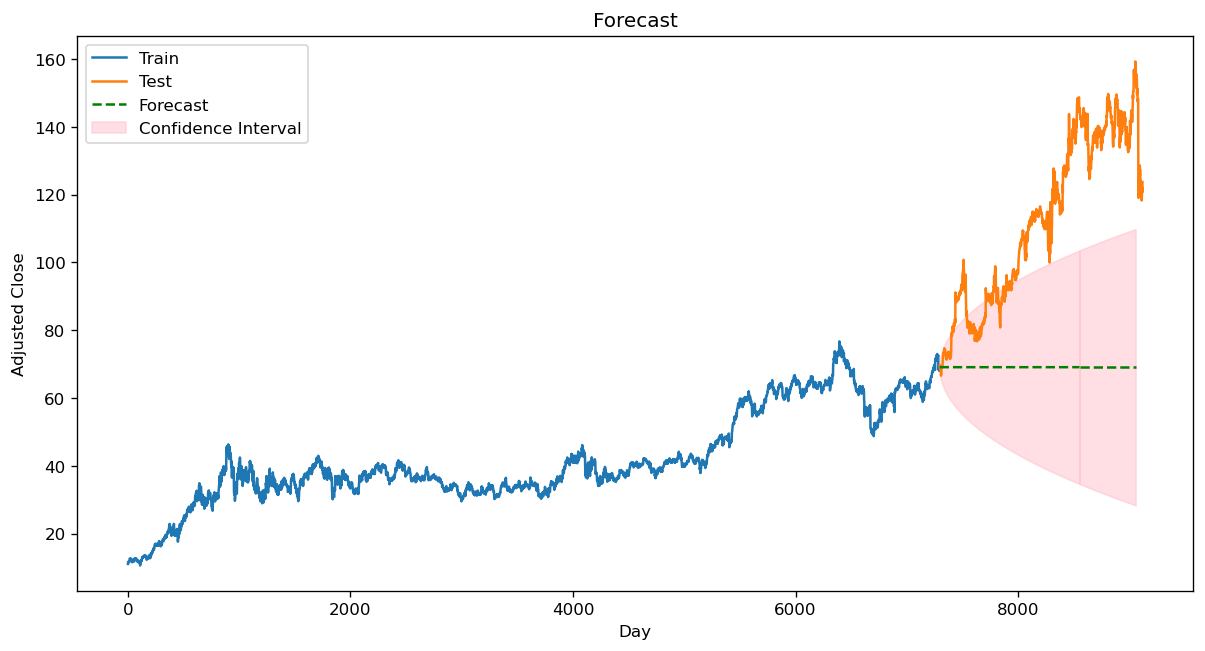

In [41]:
# Calculate the number of steps for forecasting - length of X_test (1257 days) plus another 2 years. It's worth mentioning
# that each month my vary, but the average or typical number of days each month that trading is open is about 21 days. With
# that in mind, to calculate 2 years in days, it would be 2 years x 12 months = 24 months. Then, 24 months x 21 days = 504.

forecast_steps = len(X_test) + 504

# Forecasting from the start of X_test

forecast_start_day = X_test['Day'].iloc[0]

# Forecasting

forecast = model_fit.forecast(steps = forecast_steps)

# Get confidence intervals for the extended forecast

conf_int = model_fit.get_forecast(steps = forecast_steps).conf_int()

# Generating indices for the forecast period starting from the first day of X_test

day_index = pd.RangeIndex(start = forecast_start_day, stop = forecast_start_day + forecast_steps)

# Plot graph

plt.figure(figsize = (12, 6))
plt.plot(X_train['Day'], X_train['Adj Close'], label = 'Train')
plt.plot(X_test['Day'], X_test['Adj Close'], label = 'Test')

# Plot the forecast

plt.plot(day_index[:len(X_test)], forecast[:len(X_test)], label = 'Forecast', color = 'green', linestyle = 'dashed')

# Plot confidence intervals starting from the beginning of X_test

plt.fill_between(day_index[:len(X_test)], 
                 conf_int.iloc[:len(X_test), 0], 
                 conf_int.iloc[:len(X_test), 1], 
                 label = 'Confidence Interval', color = 'pink', alpha = 0.5)

# Plot the forecast and confidence intervals with extra 90 days

plt.plot(day_index[len(X_test):], forecast[len(X_test):], color = 'green', linestyle = 'dashed')
plt.fill_between(day_index[len(X_test):], 
                 conf_int.iloc[len(X_test):, 0], 
                 conf_int.iloc[len(X_test):, 1], 
                 color = 'pink', alpha = 0.5)

plt.title('Forecast')
plt.xlabel('Day')
plt.ylabel('Adjusted Close')
plt.legend()
plt.show()

In [42]:
# Display lower and upper Adjusted Close Price range which determined the confidence interval for the forecasting.

conf_int

,lower Adj Close,upper Adj Close
5026,67.933411,70.342653
5027,67.454236,70.802368
5028,67.122416,71.121695
5029,66.859751,71.376339
5030,66.637070,71.593869
...,...,...
6782,28.425072,109.796630
6783,28.413506,109.808196
6784,28.401945,109.819758
6785,28.390386,109.831316


In [43]:
# Print mean absolute error

mae = np.mean(np.abs(model_fit.resid))
print("Mean absolute error", mae)

Mean absolute error 0.4304766661508593


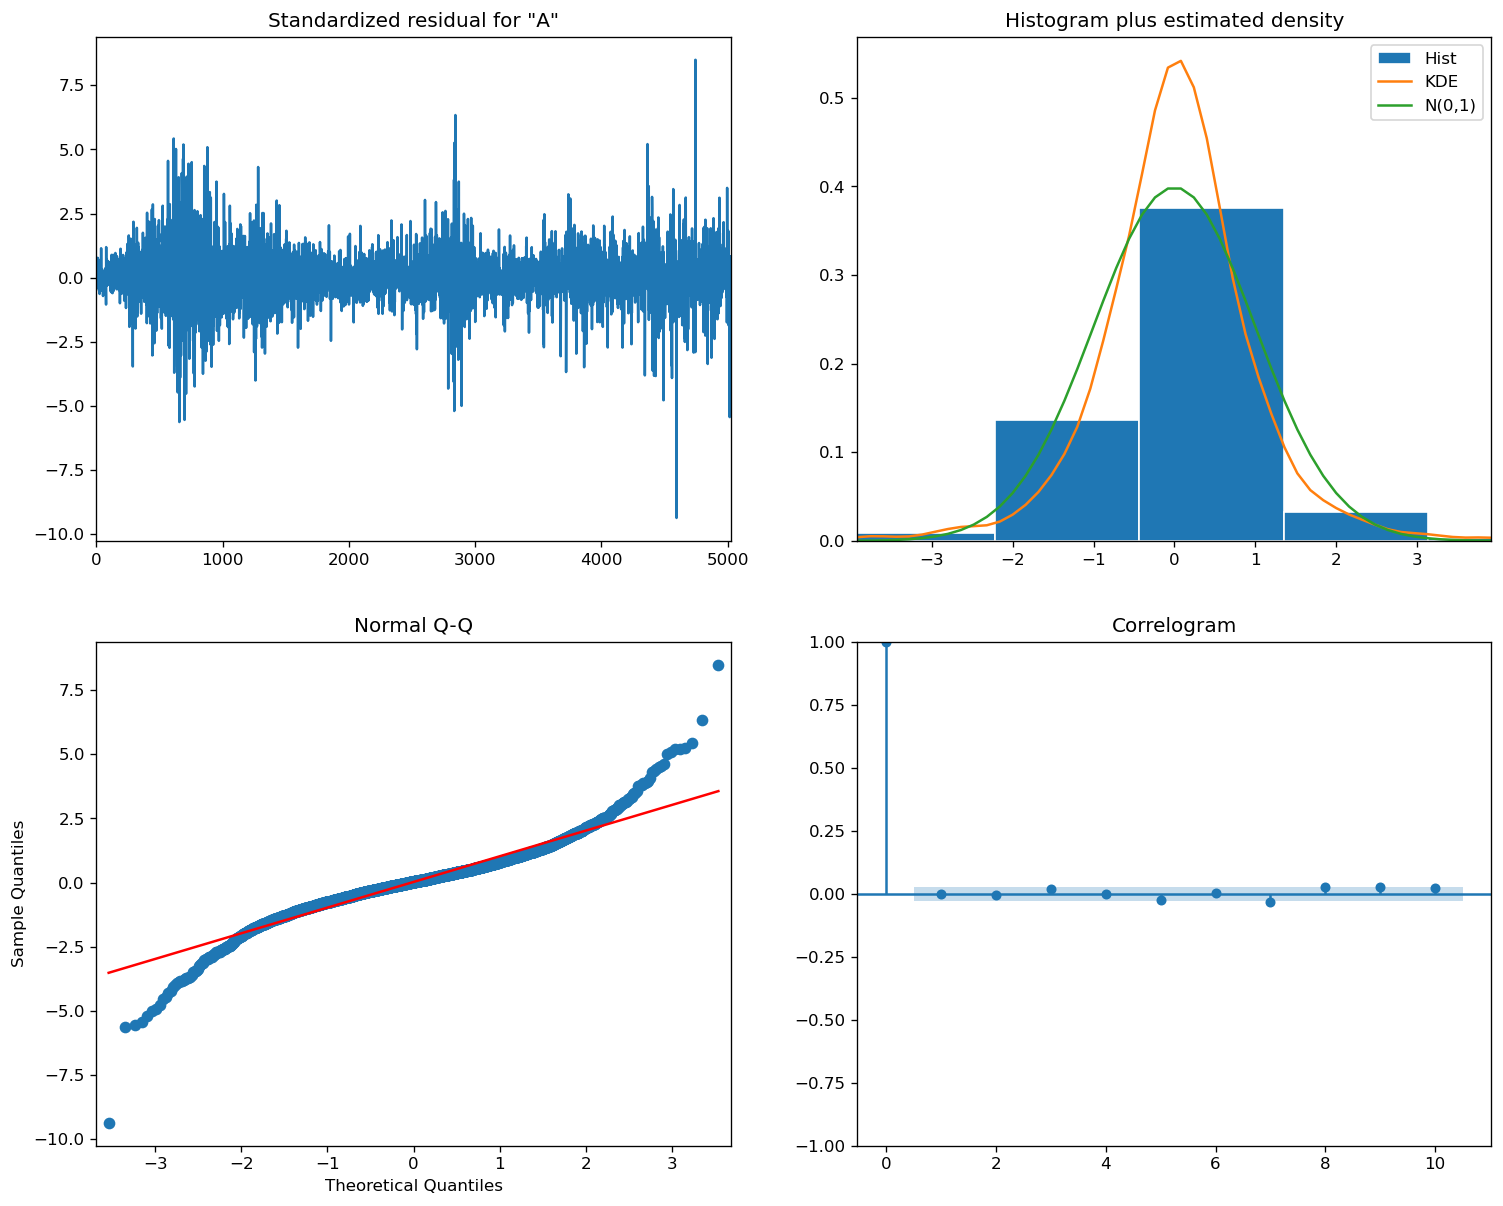

In [44]:
# Create the 4 diagnostics plots for the test

model_fit.plot_diagnostics(figsize = (15, 12)).show()

In [45]:
# Based on auto-ARIMA, the best model:  ARIMA(1,1,2)(0,0,0)[0] intercept with AIC of 9375.754
# the second set of numbers confirms no seasonality and a constant trend with an intercept. 
# Apply this best model results to the index data set before forecasting and comparing to the plotted train/test forecast

p = 1
d = 1
q = 2

# Fitting the ARIMA model on the indexed data set.

index_model = ARIMA(df3['Adj Close'], order = (p, d, q), trend = 't')
index_model_fit = index_model.fit()

# show summary of the model

print(index_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 6283
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -8381.635
Date:                Fri, 21 Jun 2024   AIC                          16773.270
Time:                        01:32:27   BIC                          16806.997
Sample:                             0   HQIC                         16784.956
                               - 6283                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0188      0.008      2.310      0.021       0.003       0.035
ar.L1          0.9693      0.010     94.949      0.000       0.949       0.989
ma.L1         -1.0086      0.011    -92.027      0.0

In [46]:
# Generate Predictions

prediction = index_model_fit.get_prediction(start = -504)

# Extract prediction mean

mean_prediction = prediction.predicted_mean

# Get confidence intervals of predictions

confidence_intervals = prediction.conf_int()

# Select lower and upper confidence limits

lower_limits = confidence_intervals['lower Adj Close']
upper_limits = confidence_intervals['upper Adj Close']

confidence_intervals

,lower Adj Close,upper Adj Close
5779,114.876054,118.477568
5780,114.306278,117.907791
5781,112.995782,116.597296
5782,113.648215,117.249729
5783,114.336647,117.938161
...,...,...
6278,119.030172,122.631686
6279,116.820670,120.422184
6280,120.482414,124.083928
6281,119.158745,122.760259


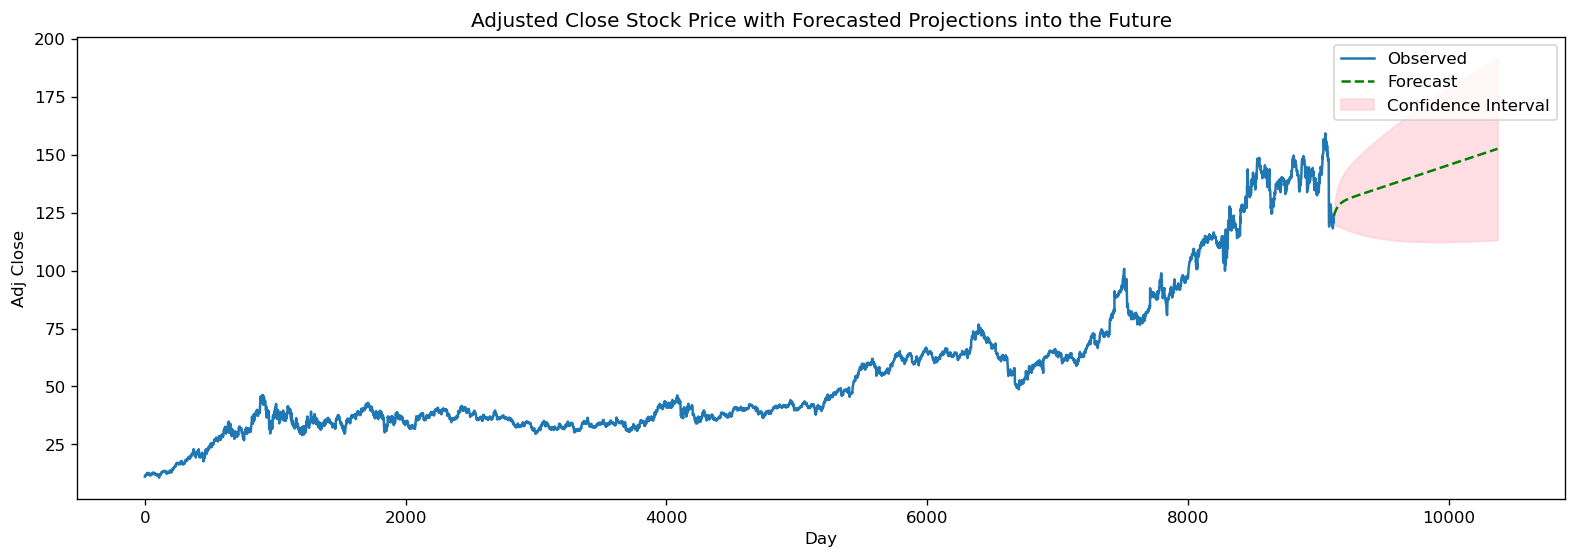

In [47]:
# Calculate the number of steps (integer) for the forecast

forecast_steps = int(len(df3) * 0.2)  

# Forecasting

forecast = index_model_fit.forecast(steps = forecast_steps)

# Get confidence intervals
index_conf_int = index_model_fit.get_forecast(steps = forecast_steps).conf_int()

# Extend the existing 'Day' index for the forecast period

last_day = df3['Day'].iloc[-1]
extended_day_index = pd.RangeIndex(start = last_day + 1, stop = last_day + 1 + forecast_steps, step = 1)

# Plot the observed data

plt.figure(figsize = (16, 5))
plt.plot(df3['Day'], df3['Adj Close'], label = 'Observed')

# Plot the forecast

plt.plot(extended_day_index, forecast, label = 'Forecast', color = 'green', linestyle = 'dashed')

# Plot confidence intervals

plt.fill_between(extended_day_index, index_conf_int.iloc[:, 0], index_conf_int.iloc[:, 1], 
                 label = 'Confidence Interval', color = 'pink', alpha = 0.5)

# Set labels, legend, and show plot

plt.title('Adjusted Close Stock Price with Forecasted Projections into the Future')
plt.xlabel('Day')
plt.ylabel('Adj Close')
plt.legend()
plt.show()

In [48]:
# Print mean absolute error 

index_mae = np.mean(np.abs(index_model_fit.resid))
print("Mean absolute error", index_mae)

Mean absolute error 0.5514951422773567


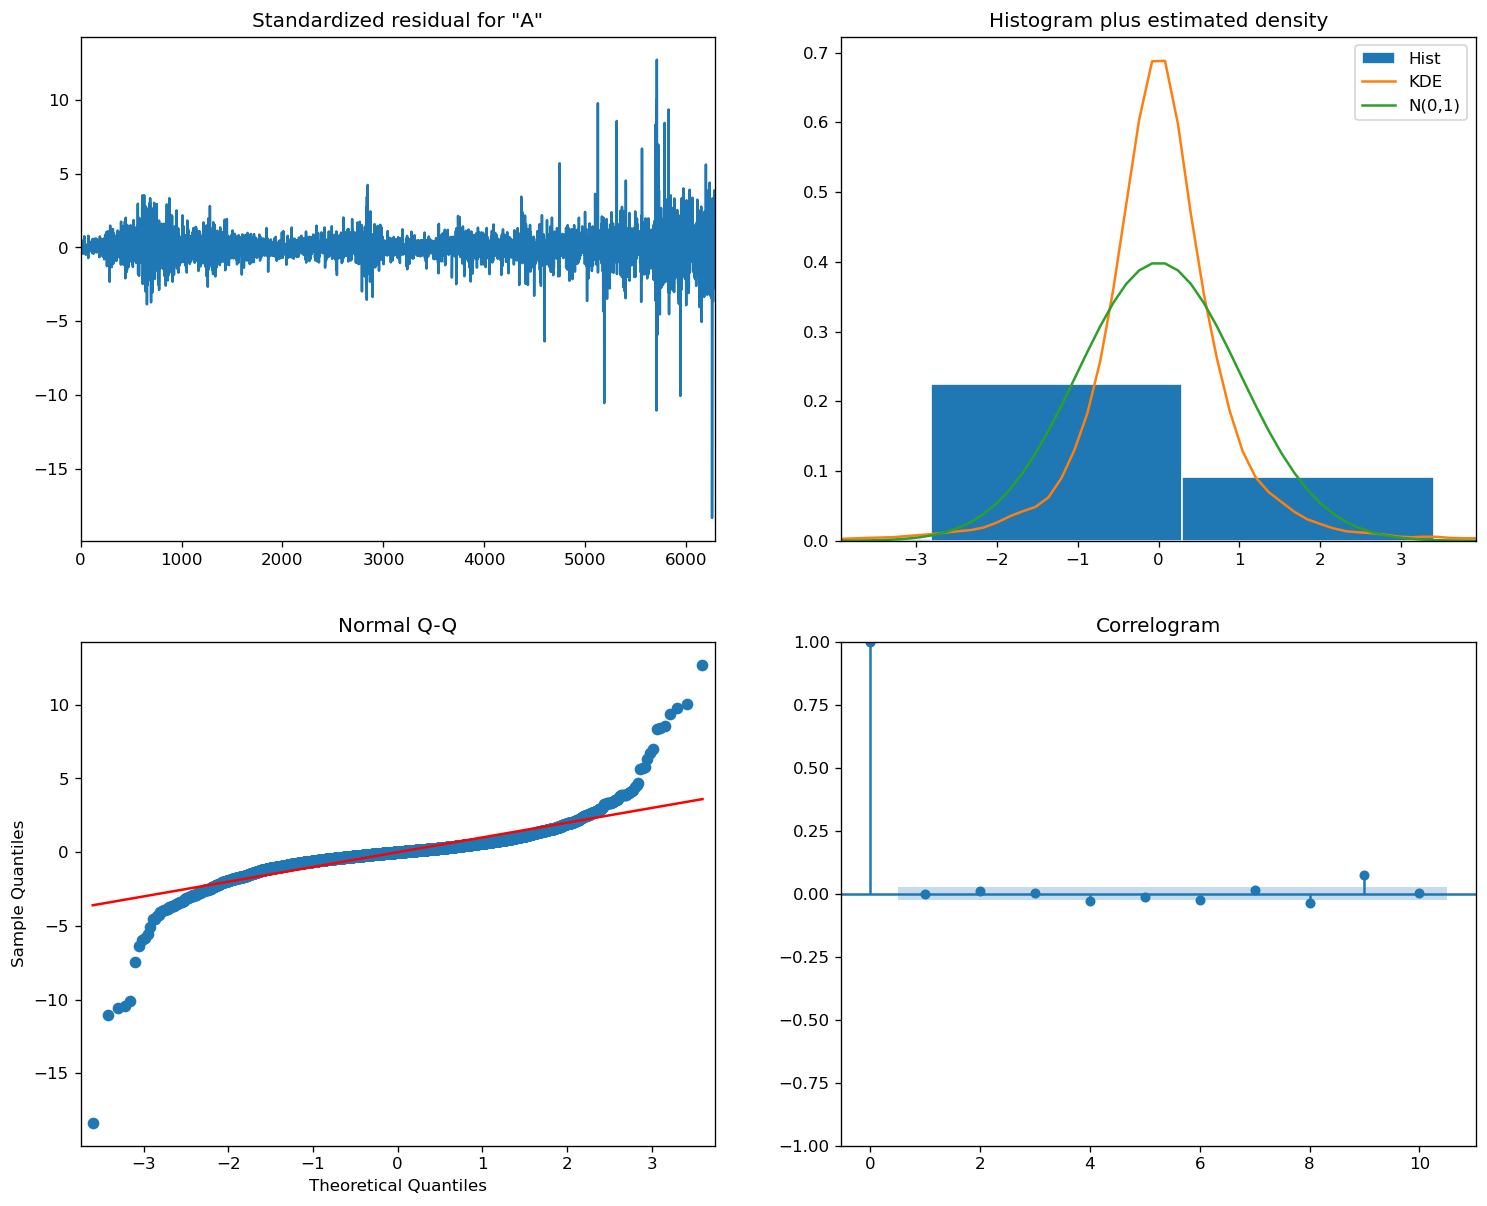

In [49]:
# Create the 4 diagnostics plots for the df

index_model_fit.plot_diagnostics(figsize = (15, 12)).show()

In [ ]:
# End of script. 